In [81]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.mlab as mlab
from scipy.stats import norm
import pylandau

#### First, open the root file with uproot and save the times to a Numpy Array

In [90]:
# events = up.open("/cwork/rck32/eic/work_eic/root_files/time_res/one_segment/mu_5GeV_2000events_2m_1cm_3cm.edm4hep.root:events")
events = up.open("/cwork/rck32/eic/work_eic/root_files/time_res/one_segment/mu_5GeV_10000events_2m_1cm_3cm.edm4hep.root:events")

times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')

#### Now we can loop over all events with the first index of the array and cut events with <2 optical photons
Goal: skip events with only 1 hit (noise) and search remaining events for first photon, ie photon with lowest time. Take that time 

In [91]:
accepted_times = []

In [92]:
#Note - array.shape[0] gives the first dimension of the array
for event_num in range(times.shape[0]):
    if(times[event_num].shape[0] < 2): continue
    accepted_times.append(min(times[event_num]))

#### We can plot the times in a histogram to visualize the result

resolution (sigma): 0.5704158544540405 | mean: 12.405163764953613 | FWHM: 1.3404772579669952


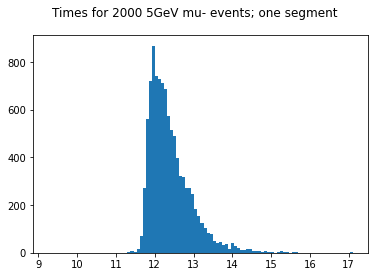

In [93]:
n_bins = 100
fig, axs = plot.subplots(1, 1)
fig.suptitle("Times for 2000 5GeV mu- events; one segment")
# We can set the number of bins with the *bins* keyword argument.
axs.hist(accepted_times, bins=n_bins)
fig.show()

#calculate std
std = np.std(accepted_times)
mean = np.mean(accepted_times)
print(f"resolution (sigma): {std} | mean: {mean} | FWHM: {2.35 * std}")


#### Now we need to calculate the standard deviation and mean of this distribution

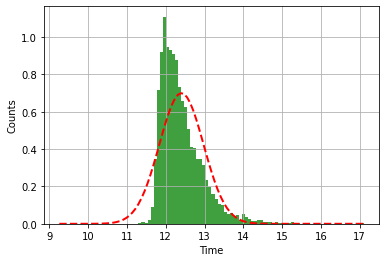

resolution (sigma): 0.5704158544540405 | mean: 12.405163764953613 | FWHM: 1.3404772579669952


In [94]:
(mu, sigma) = norm.fit(accepted_times)
n, bins, patches = plot.hist(accepted_times, 100, facecolor='green', alpha=0.75, density=True)

y = norm.pdf( bins, mu, sigma)
l = plot.plot(bins, y, 'r--', linewidth=2)
plot.xlabel('Time')
plot.ylabel('Counts')
plot.grid(True)

plot.show()
print(f"resolution (sigma): {sigma} | mean: {mu} | FWHM: {2.35 * std}")

In [120]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [121]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
    
x = np.array(accepted_times)
# x = np.random.normal(10, 5, size=10000)

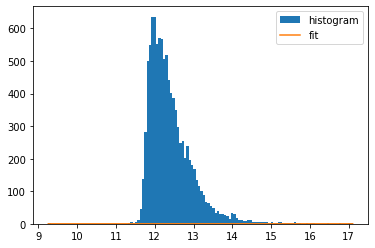

In [124]:
bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 9992)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()